# Solution for "Predicting future sales" competition at kaggle
# [Competition](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview)
# Programmer: VG6
# Date: 23.04.2020

## Setting up
Here we import modules we will work with and reading data to variables

In [1]:
import pandas as pd
from EDA_functions import brief_data_analyse, drop_duplicates, graph_insight, unreal_data_check
from EDA_functions import stationarity_test, difference, inverse_difference
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import numpy as np
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set_style('darkgrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# reading data
item_categories = pd.read_csv('Data/item_categories.csv')
items = pd.read_csv('Data/items.csv')
sales_train = pd.read_csv('Data/sales_train.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv', index_col=0)
shops = pd.read_csv('Data/shops.csv')
test = pd.read_csv('Data/test.csv')

## Getting understanding of data

### Observing data

Here we take a brief look at data. Observing first 5 rows of each dataset, getting information about types of 
each column, checking for missing and null values and getting data shape.

Data in sales train Data Frame is different from data in test Data Frame. In test Data Frame there are shop_id's and item_id's, but in sales train Data Frame we additionally have date_block_num column. In order to get same kind of data as in test, we need to group our train data by date_block_num (month), shop_id and item_id and sum for item_cnt_day. Finally we will get number of items (of item_id) sold at particular month in particular shop (shop_id)


In [3]:
brief_data_analyse(sales_train)

======= First 5 records =======
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
======= Info =======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
======= Dtypes =======
date               object
date_block_num      int64
shop_id        

In [4]:
brief_data_analyse(item_categories)

======= First 5 records =======
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
======= Info =======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
======= Dtypes =======
item_category_name    object
item_category_id       int64
dtype: object
======= Missing values =======
item_category_name    0
item_category_id      0
dtype: int64
======= Null values =======
item_category_name    0
item_category_id      0
dtype: int64
======= Data Shape =======
(84, 2)


In [5]:
brief_data_analyse(items)

======= First 5 records =======
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
======= Info =======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None
======= Dtypes =======
item_n

In [6]:
brief_data_analyse(sample_submission)

======= First 5 records =======
    item_cnt_month
ID                
0              0.5
1              0.5
2              0.5
3              0.5
4              0.5
======= Info =======
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   item_cnt_month  214200 non-null  float64
dtypes: float64(1)
memory usage: 3.3 MB
None
======= Dtypes =======
item_cnt_month    float64
dtype: object
======= Missing values =======
item_cnt_month    0
dtype: int64
======= Null values =======
item_cnt_month    0
dtype: int64
======= Data Shape =======
(214200, 1)


In [7]:
brief_data_analyse(shops)

======= First 5 records =======
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
======= Info =======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
======= Dtypes =======
shop_name    object
shop_id       int64
dtype: object
======= Missing values =======
shop_name    0
shop_id      0
dtype: int64
======= Null values =======
shop_name    0
shop_id      0
dtype: int64
======= Data Shape =======
(60, 2)


In [8]:
brief_data_analyse(test)

======= First 5 records =======
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
======= Info =======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None
======= Dtypes =======
ID         int64
shop_id    int64
item_id    int64
dtype: object
======= Missing values =======
ID         0
shop_id    0
item_id    0
dtype: int64
======= Null values =======
ID         0
shop_id    0
item_id    0
dtype: int64
======= Data Shape =======
(214200, 3)


### Checking distrubution of data in train and test set
Here we plot distribution of data in train and test sets. As we can see, distributions are different

{dtype('O'), dtype('int64'), dtype('float64')}


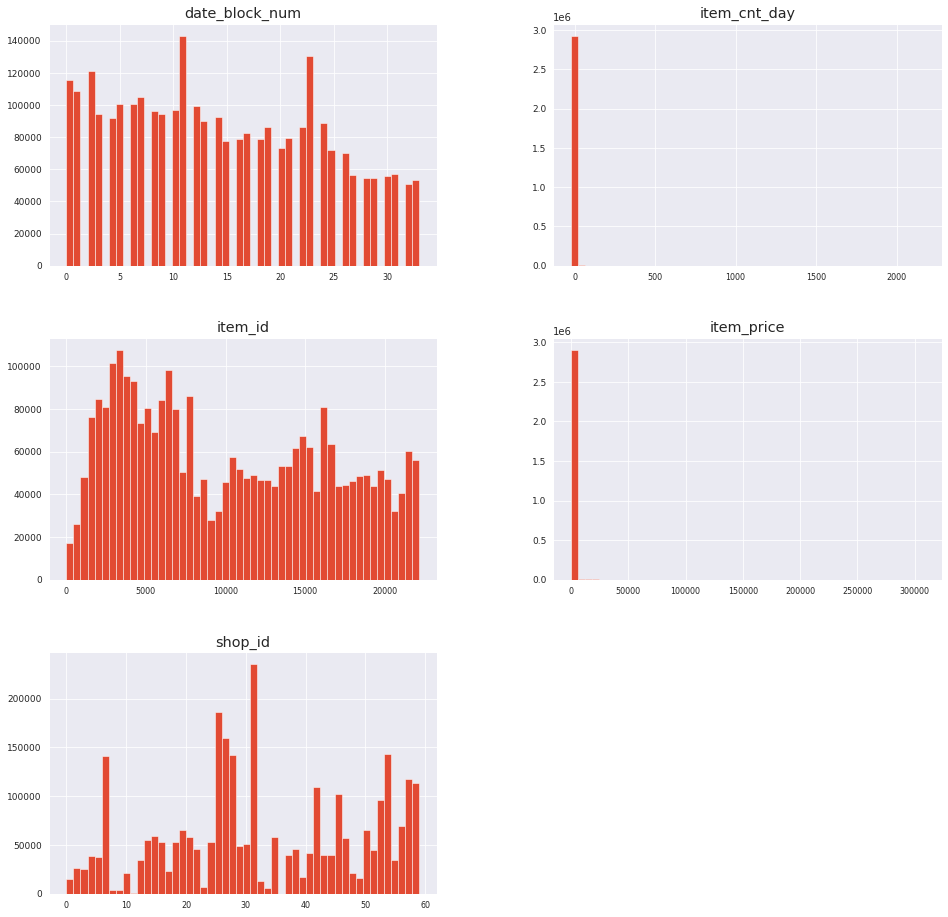

In [9]:
graph_insight(sales_train)

{dtype('int64')}


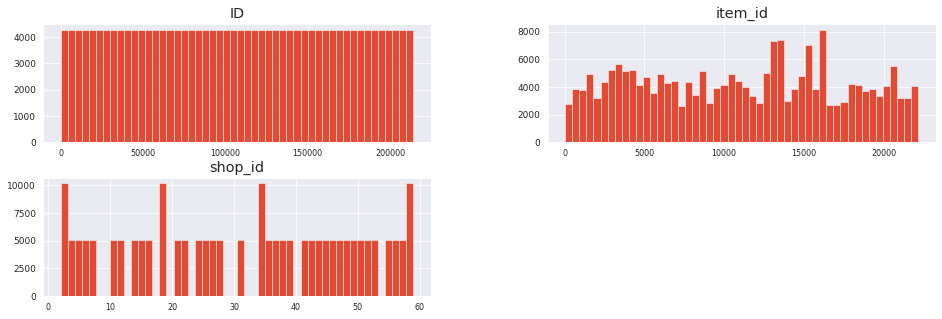

In [10]:
graph_insight(test, figsize=(16, 5))

### Getting understanding about seasonality of data

Here we can see that sales increasing at particular time of year, also we can see decreasing trend (sales decrease over the period)

We can also see that data is not stationary, beacause mean and variance are not constant over the period

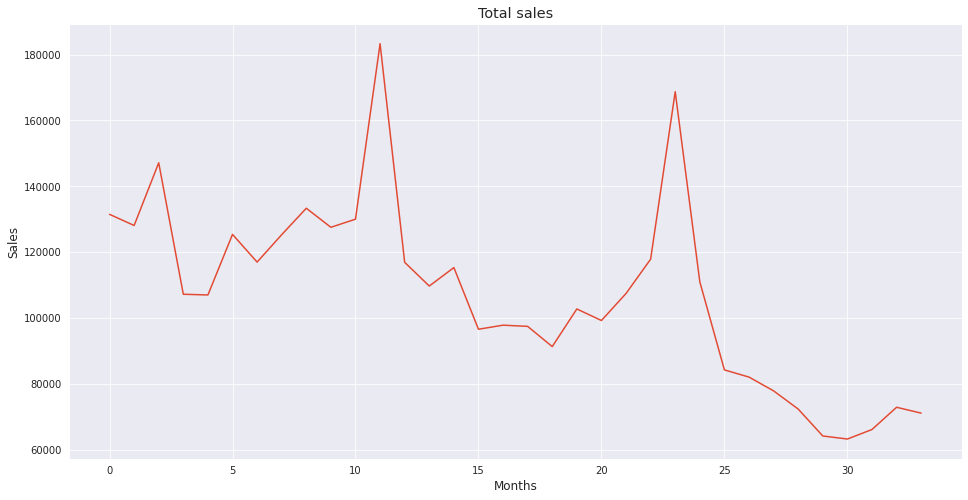

In [11]:
# getting sales per month
total_sales = sales_train.groupby('date_block_num')['item_cnt_day'].sum()

# setting up the plot
plt.figure(figsize=(16, 8))
plt.title('Total sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.plot(total_sales);

<Figure size 1152x432 with 0 Axes>

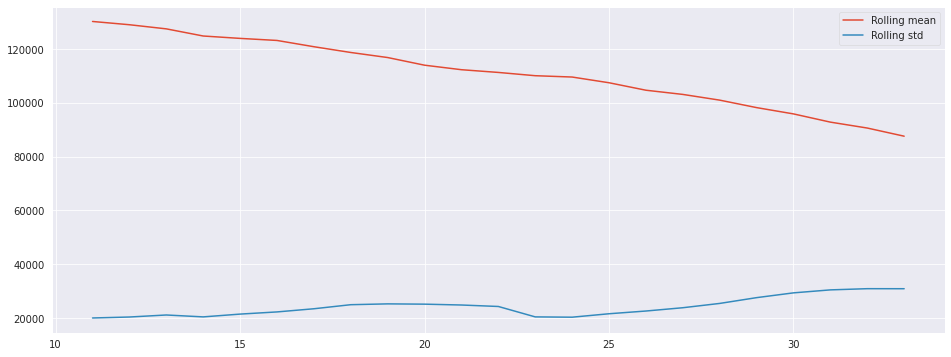

In [12]:
# setting up the plot
plt.figure(figsize=(16, 6))

# plotting mean and variance 
plt.plot(total_sales.rolling(window=12, center=False).mean(), label='Rolling mean')
plt.plot(total_sales.rolling(window=12, center=False).std(), label='Rolling std')
plt.legend()

In [13]:
# checking data for stationarity
stationarity_test(total_sales)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


<Figure size 1152x432 with 0 Axes>

Text(0.5, 1.0, 'Total sales after de-seasonalization')

Text(0.5, 0, 'Months')

Text(0, 0.5, 'Sales')

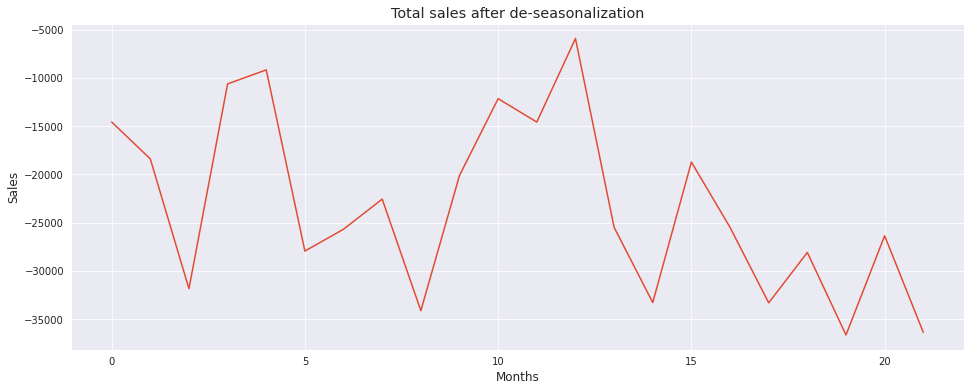

In [14]:
# getting total sales with 12 months interval
total_sales_12 = difference(total_sales, interval=12)

# setting up the plot
plt.figure(figsize=(16, 6))
plt.title('Total sales after de-seasonalization')
plt.xlabel('Months')
plt.ylabel('Sales')

# plotting sales with 12 months interval
plt.plot(total_sales_12)

In [15]:
# checking for stationarity
stationarity_test(total_sales_12)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


## Preparing sales train dataset

In [3]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [4]:
# checking for unreal values in price
# -1.0 for price doesn't look normal and 307980 also
unreal_data_check(sales_train['item_price'])

Min value:  -1.0
Max value:  307980.0
Average value:  890.8532326980126
Median value:  399.0


In [5]:
sales_train = sales_train.loc[sales_train['item_price'] < 100000]

In [6]:
median = sales_train[(sales_train.shop_id == 32) & (sales_train.item_id == 2973) & 
                          (sales_train.date_block_num == 4) & (sales_train.item_price > 0)].item_price.median()
sales_train.loc[sales_train.item_price < 0, 'item_price'] = median

In [7]:
# checking for unreal values in items sold
# -22.0 is ok, because 22 items may be returned,
# but 2169 is extremely big number of sales 
unreal_data_check(sales_train['item_cnt_day'])

Min value:  -22.0
Max value:  2169.0
Average value:  1.242640967788523
Median value:  1.0


In [8]:
sales_train = sales_train.loc[sales_train['item_cnt_day'] < 1001]

In [9]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
# dropping duplicates from data set
drop_duplicates(sales_train, ['date', 'date_block_num', 'shop_id', 'item_id','item_cnt_day'])

Shape before drop:  (2935847, 6)
Shape after drop:  (2935823, 6)
Number of duplicates:  24


### Preparing train data set in order to mimic data in test

In [11]:
# initializing array of all possible date_block_num, shop_id, item_id pairs
all_data = []

for day in tqdm(range(34)):
    sales = sales_train[sales_train['date_block_num'] == day]
    all_data.append(np.array(list(product([day], sales['shop_id'].unique(), sales['item_id'].unique())), dtype=np.int32))

100%|██████████| 34/34 [00:05<00:00,  6.55it/s]


In [12]:
train_data = pd.DataFrame(np.vstack(all_data), columns=['date_block_num', 'shop_id', 'item_id'])

train_data['date_block_num'] = train_data['date_block_num'].astype(np.int8)
train_data['shop_id'] = train_data['shop_id'].astype(np.int8)
train_data['item_id'] = train_data['item_id'].astype(np.int16)

train_data.sort_values(['date_block_num', 'shop_id', 'item_id'], inplace=True)

In [13]:
del all_data

### Getting sales by months

In [14]:
sales_train['income'] = sales_train['item_cnt_day'] * sales_train['item_price']

In [19]:
monthly_train = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day' : ['sum']})
monthly_train.columns = ['item_cnt_month']

monthly_train = pd.merge(train_data, monthly_train, how='left', on=['date_block_num', 'shop_id', 'item_id'])

monthly_train['item_cnt_month'] = monthly_train['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16)

In [20]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [21]:
monthly_train = pd.concat([monthly_train, test[['date_block_num', 'shop_id', 'item_id']]], ignore_index=True, sort=False,
                         keys=['date_block_num', 'shop_id', 'item_id'])
monthly_train.fillna(0, inplace=True)

In [22]:
monthly_train.head()
shops.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [23]:
monthly_train = pd.merge(monthly_train, items[['item_id', 'item_category_id']],
                        how='left', on=['item_id'])

monthly_train = pd.merge(monthly_train, item_categories, how='left', on='item_category_id')

monthly_train = pd.merge(monthly_train, shops, how='left', on='shop_id')

### Lagging 

In [24]:
# Generating lag features. Idea is that we shift colums values on some months
# Arguments:
#   data frame with data, lags, and needed columns
#     - df : pd.DataFrame, lags : list, col : str
# Returns:
#   lagged by column data frame
#     (pd.DataFrame)
def lag_feature(df : pd.DataFrame, lags : list, col : str) -> pd.DataFrame:
    # getting needed columns

    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    for i in lags:
        shifted = temp.copy()
        
        # specifing new lags column
        shifted.columns = ['date_block_num', 'shop_id', 'item_id',
                          col + '_lag_' + str(i)]
        
        # shifting month by i 
        shifted['date_block_num'] += i
        
        # merging data frame
        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'],
                     how='left')
        del shifted
    del temp
        
    return df

In [26]:
monthly_train = lag_feature(monthly_train, [1, 2], 'item_cnt_month')

### Mean encoding features

In [27]:
def mean_encode(data, group_by_blocks, col_name, lags):
    mean = monthly_train.groupby(group_by_blocks).agg({'item_cnt_month' : ['mean']})
    mean.columns = [col_name]
    mean.reset_index(inplace=True)

    data = pd.merge(data, mean, on=group_by_blocks, how='left')

    data[col_name] = data[col_name].astype('float16')

    data = lag_feature(data, lags, col_name)
    data.drop([col_name], axis=1, inplace=True)
    
    return data

In [28]:
monthly_train = mean_encode(monthly_train, ['date_block_num', 'item_id'], 'date_item_mean', [1, 2])

In [29]:
monthly_train = mean_encode(monthly_train, ['date_block_num', 'shop_id'], 'date_shop_mean', [1])

In [30]:
monthly_train = mean_encode(monthly_train, ['date_block_num', 'item_category_id'], 'date_category_mean', [1])

In [31]:
monthly_train = mean_encode(monthly_train, ['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_cat_mean', [1])

In [32]:
monthly_train = mean_encode(monthly_train, ['date_block_num'], 'date_mean', [1])

In [33]:
monthly_train = monthly_train.fillna(0.0)

In [34]:
monthly_train.to_csv("Data/Some_features_encoded.csv")

### Generating new features

In [4]:
monthly_train = pd.read_csv('Data/Some_features_encoded.csv', index_col=0)

In [35]:
monthly_train.loc[monthly_train['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [36]:
monthly_train['category_name'] = monthly_train['item_category_name'].apply(lambda x: x.split()[0])
monthly_train['city'] = monthly_train['shop_name'].apply(lambda x: x.split()[0])
monthly_train['kind_of_shop'] = monthly_train['shop_name'].apply(lambda x: x.split()[1])

In [37]:
# taking a look at category names
monthly_train['category_name'].unique()

array(['Кино', 'Игры', 'Музыка', 'Книги', 'Программы', 'Подарки',
       'Аксессуары', 'Игровые', 'Карты', 'Доставка', 'Чистые', 'PC',
       'Служебные', 'Элементы', 'Билеты'], dtype=object)

In [38]:
# taking a look at city
monthly_train['city'].unique()

array(['Адыгея', 'Балашиха', 'Волжский', 'Воронеж', 'Жуковский',
       'Интернет-магазин', 'Казань', 'Калуга', 'Коломна', 'Красноярск',
       'Курск', 'Москва', 'Н.Новгород', 'Новосибирск', 'Омск',
       'РостовНаДону', 'СПб', 'Самара', 'СергиевПосад', 'Сургут',
       'Тюмень', 'Уфа', 'Химки', 'Чехов', 'Якутск', 'Ярославль',
       'Вологда', 'Цифровой', 'Выездная', 'Томск', 'Мытищи'], dtype=object)

In [39]:
# replacing !Якутск with Якутск because this is the same city
monthly_train['city'] = monthly_train['city'].apply(lambda x: re.sub('!Якутск', 'Якутск', x))

In [40]:
# taking a look at king of shop
monthly_train['kind_of_shop'].unique()

array(['ТЦ', 'ТРК', '(Плехановская,', 'ТРЦ', 'ул.', 'ЧС', 'МТРЦ',
       'Магазин', 'ТК', 'Орджоникидзе,', 'склад', 'Торговля',
       '"Распродажа"'], dtype=object)

In [42]:
monthly_train = monthly_train.drop(['item_category_id', 'item_category_name', 'shop_name'], axis=1)

In [7]:
monthly_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,date_item_mean_lag_1,date_item_mean_lag_2,date_shop_mean_lag_1,date_category_mean_lag_1,date_shop_cat_mean_lag_1,date_mean_lag_1,category_name,city,kind_of_shop,month,item_price_mean,date_item_price_mean
0,0,2,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино,Адыгея,ТЦ,0,28.000000,28.000000
1,0,2,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Игры,Адыгея,ТЦ,0,1461.228571,2325.000000
2,0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Игры,Адыгея,ТЦ,0,310.010465,549.000000
3,0,2,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Игры,Адыгея,ТЦ,0,1759.285714,2397.500000
4,0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино,Адыгея,ТЦ,0,249.629240,338.110349


In [44]:
monthly_train['month'] = monthly_train['date_block_num'] % 12

In [2]:
monthly_train = pd.read_csv('Data/almonst_full.csv', index_col=0)

In [6]:
monthly_train = monthly_train.drop(['item_price_mean_x', 'item_price_mean_y'], axis=1)

### Encoding new features

In [8]:
label_encoder = LabelEncoder()

In [9]:
monthly_train['category_name'] = label_encoder.fit_transform(monthly_train['category_name'])
monthly_train['city'] = label_encoder.fit_transform(monthly_train['city'])
monthly_train['kind_of_shop'] = label_encoder.fit_transform(monthly_train['kind_of_shop'])

In [11]:
monthly_train = monthly_train.drop('category_name', axis=1)

In [13]:
monthly_train['date_block_num'] = monthly_train['date_block_num'].astype('uint8')
monthly_train['shop_id'] = monthly_train['shop_id'].astype('uint16')
monthly_train['item_id'] = monthly_train['item_id'].astype('uint16')
monthly_train['city'] = monthly_train['shop_id'].astype('uint16')
monthly_train['kind_of_shop'] = monthly_train['kind_of_shop'].astype('uint16')


In [14]:
monthly_train.to_csv('Data/Prepared_data.csv')

## Making modeling

#### Xgb model

In [2]:
monthly_train = pd.read_csv('Data/Prepared_data.csv', index_col=0)

In [3]:
monthly_train = monthly_train.fillna(0.0)

In [4]:
monthly_train.tail()

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,date_item_mean_lag_1,date_item_mean_lag_2,date_shop_mean_lag_1,date_category_mean_lag_1,date_shop_cat_mean_lag_1,date_mean_lag_1,city,kind_of_shop,month,item_price_mean,date_item_price_mean
11127999,34,45,18454,0.0,1.0,0.0,0.04544,0.02325,0.1267,0.1969,0.12680,0.2585,45,8,10,188.681084,0.0
11128000,34,45,16188,0.0,0.0,0.0,0.02272,0.06976,0.1267,0.1559,0.09450,0.2585,45,8,10,1256.975000,0.0
11128001,34,45,15757,0.0,0.0,0.0,0.11365,0.06976,0.1267,0.1969,0.12680,0.2585,45,8,10,198.113208,0.0
11128002,34,45,19648,0.0,0.0,0.0,0.04544,0.06976,0.1267,0.2208,0.08374,0.2585,45,8,10,98.096296,0.0
11128003,34,45,969,0.0,0.0,0.0,0.06820,0.11630,0.1267,0.2568,0.12820,0.2585,45,8,10,502.297061,0.0


In [5]:
X_train = monthly_train[monthly_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = monthly_train[monthly_train.date_block_num < 33]['item_cnt_month']

X_val = monthly_train[monthly_train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val = monthly_train[monthly_train.date_block_num == 33]['item_cnt_month']

X_test = monthly_train[monthly_train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
model = xgb.XGBRegressor(max_depth=8,
                        n_estimators=1000,
                        min_child_weight=300,
                        colsample_bytree=0.8,
                        subsample=0.8,
                        eta=0.2,
                        seed=42)

model.fit(X_train, y_train, eval_metric='rmse',
         eval_set=[(X_train, y_train), (X_val, y_val)], 
         verbose=True,
         early_stopping_rounds = 10)

[17:41:30] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15799	validation_1-rmse:1.09231
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08402	validation_1-rmse:1.04498
[2]	validation_0-rmse:1.04398	validation_1-rmse:1.01574
[3]	validation_0-rmse:1.01405	validation_1-rmse:0.99721
[4]	validation_0-rmse:0.98912	validation_1-rmse:0.98153
[5]	validation_0-rmse:0.97147	validation_1-rmse:0.97171
[6]	validation_0-rmse:0.95950	validation_1-rmse:0.96627
[7]	validation_0-rmse:0.95091	validation_1-rmse:0.96165
[8]	validation_0-rmse:0.94469	validation_1-rmse:0.95923
[9]	validation_0-rmse:0.94043	validation_1-rmse:0.95713
[10]	validation_0-rmse:0.93686	validation_1-rmse:0.95548
[11]	va

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.200000003, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [9]:
y_val_pred = model.predict(X_val)

In [10]:
np.save('Data/y_val_xgb', y_val_pred)

In [32]:
test = pd.read_csv('Data/test.csv')

In [8]:
y_test = model.predict(X_test).clip(0, 20)

In [9]:
submission = pd.DataFrame({
    'ID' : test.index,
    'item_cnt_month' : y_test
})

In [10]:
submission.to_csv('xgb_submission.csv', index=False)

In [11]:
del model

#### LSTM model

In [2]:
monthly_train = pd.read_csv('Data/Prepared_data.csv', index_col=0)

In [3]:
monthly_train = monthly_train.fillna(0.0)

In [4]:
X_train = monthly_train[monthly_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = monthly_train[monthly_train.date_block_num < 33]['item_cnt_month']

X_val = monthly_train[monthly_train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val = monthly_train[monthly_train.date_block_num == 33]['item_cnt_month']

X_test = monthly_train[monthly_train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [5]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [5]:
model_lstm = Sequential()
model_lstm.add(LSTM(15, input_shape=(1, 16)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))

X_train_scales = scaler.fit_transform(X_train)
X_val_scales = scaler.fit_transform(X_val)
X_test_scales = scaler.fit_transform(X_test)

In [7]:
X_train_reshapes = X_train_scales.reshape((X_train_scales.shape[0], 1, X_train_scales.shape[1]))
X_val_reshapes = X_val_scales.reshape((X_val_scales.shape[0], 1, X_val_scales.shape[1]))
X_test_reshapes = X_test_scales.reshape((X_test_scales.shape[0], 1, X_test_scales.shape[1]))

In [8]:
history = model_lstm.fit(X_train_reshapes, y_train, validation_data=(X_val_reshapes, y_val),
                        epochs=20, batch_size=1000, verbose=1, shuffle=False)

Train on 10675632 samples, validate on 238172 samples
Epoch 1/20
10675632/10675632 [==============================] - 19s 2us/step - loss: 1.0343 - accuracy: 0.8154 - val_loss: 4.7588 - val_accuracy: 0.1778
Epoch 2/20
10675632/10675632 [==============================] - 18s 2us/step - loss: 0.9582 - accuracy: 0.8207 - val_loss: 2.4739 - val_accuracy: 0.3120
Epoch 3/20
10675632/10675632 [==============================] - 18s 2us/step - loss: 0.9458 - accuracy: 0.8214 - val_loss: 1.6069 - val_accuracy: 0.3463
Epoch 4/20
10675632/10675632 [==============================] - 18s 2us/step - loss: 0.9398 - accuracy: 0.8218 - val_loss: 1.3011 - val_accuracy: 0.4164
Epoch 5/20
10675632/10675632 [==============================] - 18s 2us/step - loss: 0.9355 - accuracy: 0.8219 - val_loss: 1.1623 - val_accuracy: 0.5556
Epoch 6/20
10675632/10675632 [==============================] - 18s 2us/step - loss: 0.9321 - accuracy: 0.8219 - val_loss: 1.0720 - val_accuracy: 0.7104
Epoch 7/20
10675632/10675632

In [10]:
y_val_pred = model_lstm.predict(X_val_reshapes)

In [11]:
np.save('Data/y_val_lstm', y_val_pred)

In [14]:
y_test = model_lstm.predict(X_test_reshapes).clip(0, 20)

In [22]:
test = pd.read_csv('Data/test.csv')

In [19]:
y_test = [record[0] for record in y_test]

In [23]:
submission = pd.DataFrame({
    'ID' : test.index,
    'item_cnt_month' : y_test
})

In [24]:
submission.to_csv('Data/LSTM_submission.csv')

#### Linear regression model

In [2]:
monthly_train = pd.read_csv('Data/Prepared_data.csv', index_col=0)

In [3]:
monthly_train = monthly_train.fillna(0.0)

In [4]:
X_train = monthly_train[monthly_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = monthly_train[monthly_train.date_block_num < 33]['item_cnt_month']

X_val = monthly_train[monthly_train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val = monthly_train[monthly_train.date_block_num == 33]['item_cnt_month']

X_test = monthly_train[monthly_train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [5]:
model_lr = LinearRegression().fit(X_train, y_train)

In [6]:
y_val_pred = model_lr.predict(X_val)

In [7]:
print(r2_score(y_val, y_val_pred))

0.26349261535362667


In [8]:
print(mean_squared_error(y_val, y_val_pred))

0.950711181017935


In [9]:
y_test = model_lr.predict(X_test)

In [12]:
test = pd.read_csv('Data/test.csv')

In [10]:
y_test

array([ 0.26845817,  0.20084898,  1.02359446, ...,  0.04567058,
       -0.00423424,  0.0463804 ])

In [13]:
submission = pd.DataFrame({
    'ID' : test.index,
    'item_cnt_month' : y_test
})

In [14]:
submission.to_csv('Data/Lr.csv')

In [16]:
np.save('Data/y_val_lr', y_val_pred)

### Making ensemble

In [2]:
monthly_train = pd.read_csv('Data/Prepared_data.csv', index_col=0)

In [3]:
monthly_train = monthly_train.fillna(0.0)

In [4]:
X_train = monthly_train[monthly_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = monthly_train[monthly_train.date_block_num < 33]['item_cnt_month']

X_val = monthly_train[monthly_train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val = monthly_train[monthly_train.date_block_num == 33]['item_cnt_month']

X_test = monthly_train[monthly_train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [5]:
y_val_lstm = np.load('Data/y_val_lstm.npy')
y_val_xgb = np.load('Data/y_val_xgb.npy')
y_val_lr = np.load('Data/y_val_lr.npy')

In [8]:
y_val_lstm

array([[0.04018569],
       [0.05603868],
       [0.2848333 ],
       ...,
       [0.06867206],
       [0.0514484 ],
       [0.14212394]], dtype=float32)

In [9]:
y_val_lstm = [x[0] for x in y_val_lstm]

In [23]:
train = pd.DataFrame({'lstm' : y_val_lstm, 'xgb' : y_val_xgb, 'lr' : y_val_lr})

In [24]:
model = LinearRegression()

In [25]:
model.fit(train, y_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
y_val_pred = model.predict(train)

In [27]:
mean_squared_error(y_val_pred, y_val)

0.9016665607523894

In [28]:
r2_score(y_val_pred, y_val)

-1.316892154451053

In [31]:
y_test_lstm = pd.read_csv('Data/LSTM_submission.csv', index_col=0)['item_cnt_month'].values

In [32]:
y_test_lstm

array([0.50251073, 0.13355738, 1.19719255, ..., 0.29971504, 0.24980682,
       0.26679975])

In [33]:
y_test_xgb = pd.read_csv('xgb_submission.csv', index_col=0)['item_cnt_month'].values

In [34]:
y_test_xgb

array([0.8444514 , 0.7428379 , 1.3768667 , ..., 0.0699366 , 0.04952243,
       0.03589451])

In [35]:
y_test_lr = pd.read_csv('Data/Lr.csv', index_col=0)['item_cnt_month'].values

In [36]:
y_test_lr

array([ 0.26845817,  0.20084898,  1.02359446, ...,  0.04567058,
       -0.00423424,  0.0463804 ])

In [37]:
test = pd.DataFrame({'lstm' : y_test_lstm, 'xgb' : y_test_xgb, 'lr' : y_test_lr})

In [38]:
y_test = model.predict(test)

In [39]:
submission = pd.DataFrame({
    'ID' : test.index,
    'item_cnt_month' : y_test
})

In [40]:
submission.to_csv('Data/Ensembled.csv')

In [2]:
import pandas as pd
submission = pd.read_csv('Data/Ensembled.csv')

In [6]:
submission = submission[['ID', 'item_cnt_month']]

In [8]:
submission.to_csv('Data/Ensembled.csv', index=False)